In [380]:
# Cell 1: Import Libraries
import os
import pandas as pd
import numpy as np
import boto3
from botocore.client import Config
from botocore.exceptions import ClientError
from io import BytesIO
from datetime import datetime

# IMPORTANT: Ensure pyarrow is installed for reading Parquet files
# If not, run: !pip install pyarrow
import pyarrow.parquet as pq

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# --- Global Configuration ---
TARGET_SYMBOL = "MSFT" # Change this symbol to analyze different stocks (e.g., "AAPL", "GOOGL", "AMZN")
# --- End Global Configuration ---

In [381]:
# Cell 2: Load MinIO Details from Environment Variables
# These MUST be set in your Windows environment before launching Jupyter
MINIO_ENDPOINT = os.getenv("MINIO_ENDPOINT", 'http://localhost:9000')
MINIO_ACCESS_KEY = os.getenv("MINIO_ACCESS_KEY")
MINIO_SECRET_KEY = os.getenv("MINIO_SECRET_KEY")

# Basic validation (optional in notebook, but good for clarity)
if not MINIO_ACCESS_KEY or not MINIO_SECRET_KEY:
    print("Error: MinIO credentials not loaded. Please set environment variables.")
    # You might want to halt execution or load from a config file here for notebooks
else:
    print("MinIO credentials loaded successfully.")


MinIO credentials loaded successfully.


In [382]:
# Cell 3: Initialize MinIO S3 client
s3_client = None
try:
    s3_client = boto3.client(
        's3',
        endpoint_url=MINIO_ENDPOINT,
        aws_access_key_id=MINIO_ACCESS_KEY,
        aws_secret_access_key=MINIO_SECRET_KEY,
        config=Config(signature_version='s3v4'),
        region_name='us-east-1' # Placeholder region
    )
    s3_client.list_buckets() # Test connection
    print(f"MinIO S3 client initialized and connected to endpoint: {MINIO_ENDPOINT}")
except Exception as e:
    print(f"Error initializing or connecting to MinIO S3 client: {e}")
    print("Please ensure MinIO Docker container is running and accessible.")
    s3_client = None # Set to None if initialization fails


MinIO S3 client initialized and connected to endpoint: http://localhost:9000


In [383]:
# Cell 4: Helper Function to Read Processed Parquet Data for a Symbol
def load_processed_data_from_minio(bucket_name, data_type_prefix, symbol):
    if not s3_client:
        print("MinIO client not available, cannot load data.")
        return pd.DataFrame()

    all_dataframes = []
    # Construct the prefix to look for processed data for a specific symbol
    # Example: processed-financial-data/finnhub_quotes/AAPL/
    # Or: processed-financial-data/twelvedata_historical/AAPL/
    prefix = f"{data_type_prefix}/{symbol}/"

    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

        for page in pages:
            if "Contents" in page:
                for obj in page['Contents']:
                    if obj['Key'].endswith('.parquet'):
                        try:
                            response = s3_client.get_object(Bucket=bucket_name, Key=obj['Key'])
                            parquet_data = response['Body'].read()
                            df = pd.read_parquet(BytesIO(parquet_data))
                            all_dataframes.append(df)
                        except Exception as e:
                            print(f"Error reading {obj['Key']} from MinIO: {e}")
        if all_dataframes:
            # Concatenate all dataframes and sort by the relevant timestamp/datetime column
            combined_df = pd.concat(all_dataframes, ignore_index=True)

            # Convert to datetime, force UTC, then localize to naive (no timezone info)
            if 'datetime' in combined_df.columns:
                combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], utc=True, errors='coerce')
                combined_df['datetime'] = combined_df['datetime'].dt.tz_localize(None)
                combined_df = combined_df.sort_values(by='datetime').drop_duplicates(subset=['datetime']).set_index('datetime')
            elif 'timestamp' in combined_df.columns:
                combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'], utc=True, errors='coerce')
                combined_df['timestamp'] = combined_df['timestamp'].dt.tz_localize(None)
                combined_df = combined_df.sort_values(by='timestamp').drop_duplicates(subset=['timestamp']).set_index('timestamp')

            return combined_df
        else:
            print(f"No processed data found for {symbol} under {data_type_prefix}.")
            return pd.DataFrame()
    except ClientError as e:
        print(f"MinIO Client Error when listing objects in s3://{bucket_name}/{prefix}: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"General error loading data for {symbol} from MinIO: {e}")
        return pd.DataFrame()

In [384]:
# Cell 5: Load and Inspect Finnhub Quotes for AAPL
processed_finnhub_quotes_df = load_processed_data_from_minio(
    bucket_name="processed-financial-data",
    data_type_prefix="finnhub_quotes",
    symbol=TARGET_SYMBOL # Use the global configuration variable
)

print(f"\nProcessed Finnhub Quotes for {TARGET_SYMBOL} (first 5 rows):")
print(processed_finnhub_quotes_df.head())
print(f"\nProcessed Finnhub Quotes Info for {TARGET_SYMBOL}:")
processed_finnhub_quotes_df.info()


Processed Finnhub Quotes for MSFT (first 5 rows):
                             close    high     low    open  prev_close  \
timestamp                                                                
2025-06-16 09:55:58.324061  100.00  102.00   98.00   99.00       98.50   
2025-06-20 19:45:53.837398  100.00  102.00   98.00   99.00       98.50   
2025-06-21 00:12:30.565278  100.00  102.00   98.00   99.00       98.50   
NaT                         474.96  479.18  472.76  476.41      478.87   

                            spread symbol            fetch_timestamp  
timestamp                                                             
2025-06-16 09:55:58.324061    4.00   MSFT 2025-06-16 09:55:58.324065  
2025-06-20 19:45:53.837398    4.00   MSFT 2025-06-20 19:45:53.837403  
2025-06-21 00:12:30.565278    4.00   MSFT 2025-06-21 00:12:30.565281  
NaT                           6.42   MSFT 2025-06-15 02:43:24.334989  

Processed Finnhub Quotes Info for MSFT:
                             close   

In [385]:
# Cell 6: Load and Inspect Twelve Data Historical for AAPL
processed_twelvedata_historical_df = load_processed_data_from_minio(
    bucket_name="processed-financial-data",
    data_type_prefix="twelvedata_historical",
    symbol=TARGET_SYMBOL # Use the global configuration variable
)

print(f"\nProcessed Twelve Data Historical for {TARGET_SYMBOL} (first 5 rows):")
print(processed_twelvedata_historical_df.head())
print(f"\nProcessed Twelve Data Historical Info for {TARGET_SYMBOL}:")
processed_twelvedata_historical_df.info()



Processed Twelve Data Historical for MSFT (first 5 rows):
                 open        high        low      close    volume  \
datetime                                                            
2022-07-25  261.00000  261.500000  256.81000  258.82999  21056000   
2022-07-26  259.85999  259.880000  249.57001  251.89999  39348000   
2022-07-27  261.16000  270.049988  258.85001  268.73999  45994000   
2022-07-28  269.75000  277.840000  267.87000  276.41000  33459300   
2022-07-29  277.70001  282.000000  276.63000  280.73999  32152800   

            daily_return symbol fetch_timestamp  range  
datetime                                                
2022-07-25           NaN   MSFT             NaT    NaN  
2022-07-26     -0.026774   MSFT             NaT    NaN  
2022-07-27      0.066852   MSFT             NaT    NaN  
2022-07-28      0.028541   MSFT             NaT    NaN  
2022-07-29      0.015665   MSFT             NaT    NaN  

Processed Twelve Data Historical Info for MSFT:
<class 'p

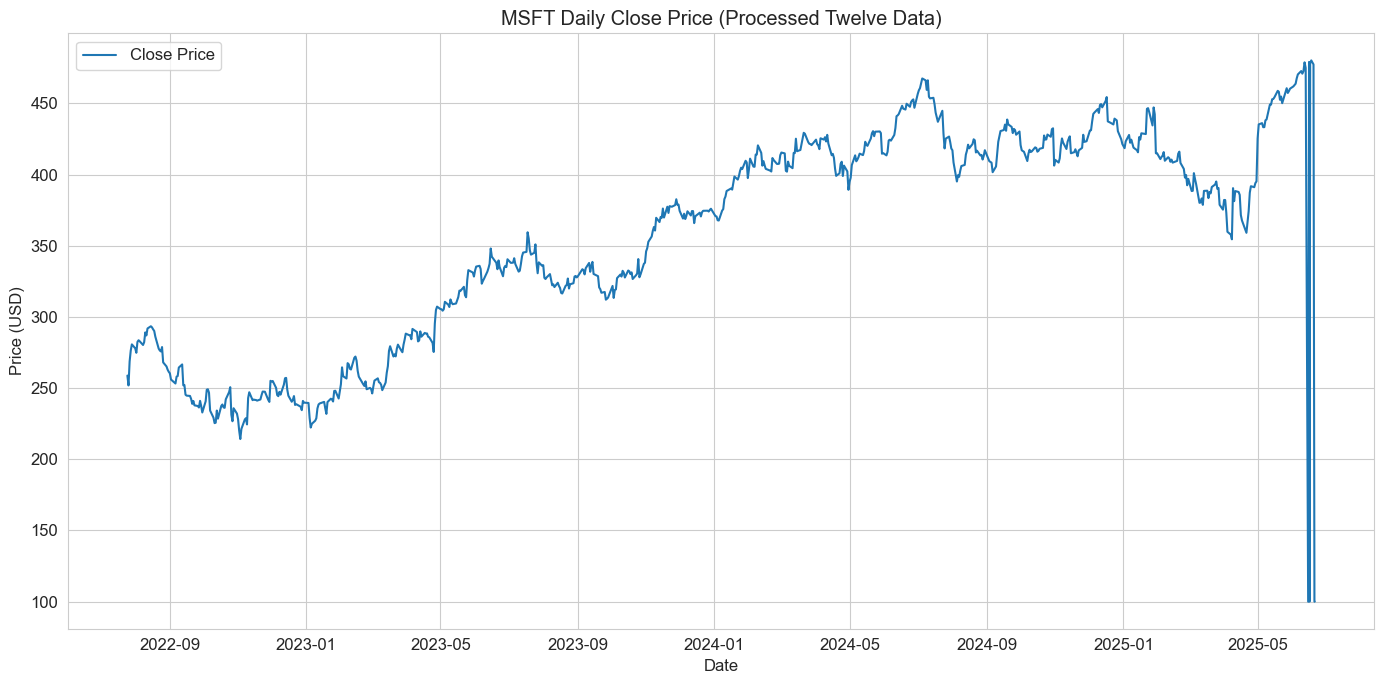

In [386]:
# Cell 7: Basic Visualization - Twelve Data Historical Close Price
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price')
    plt.title(f'{TARGET_SYMBOL} Daily Close Price (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to plot Twelve Data historical close price for AAPL.")

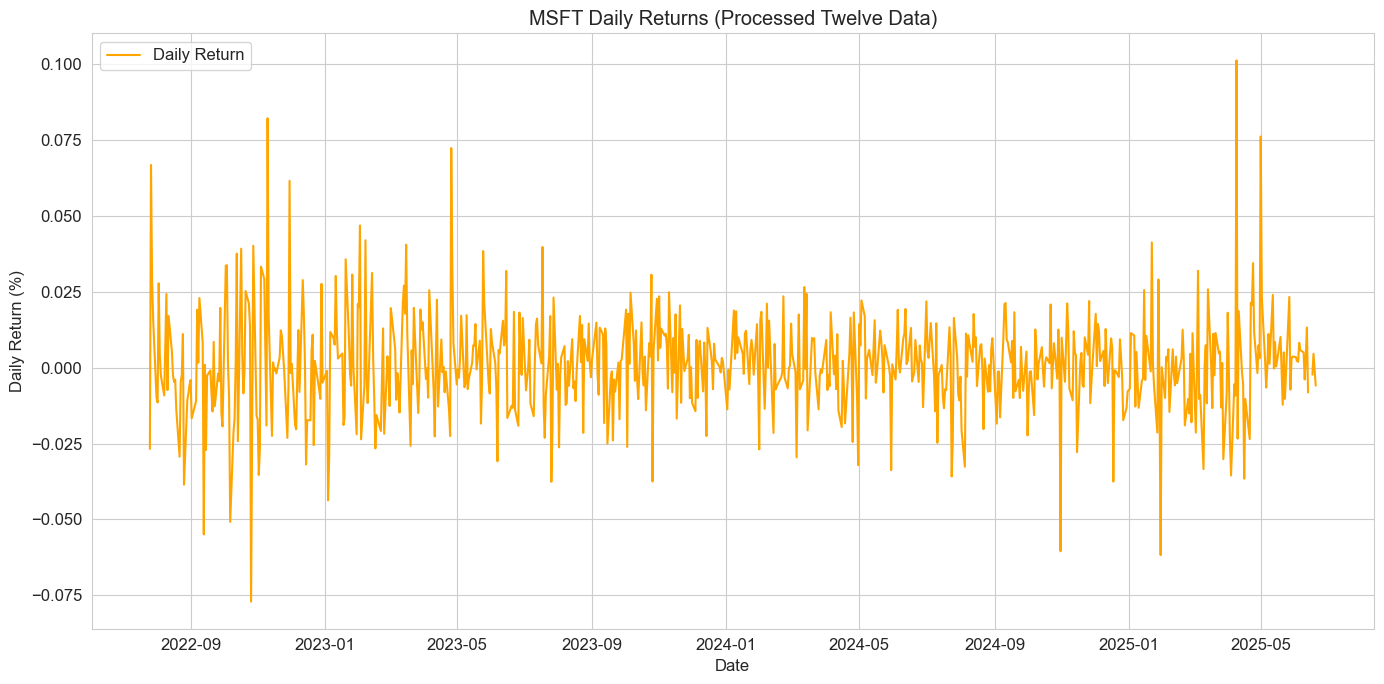

In [387]:
# Cell 8: Basic Visualization - Twelve Data Daily Returns
if not processed_twelvedata_historical_df.empty and 'daily_return' in processed_twelvedata_historical_df.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['daily_return'], label='Daily Return', color='orange')
    plt.title(f'{TARGET_SYMBOL} Daily Returns (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Daily Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data to plot Twelve Data daily returns for AAPL.")


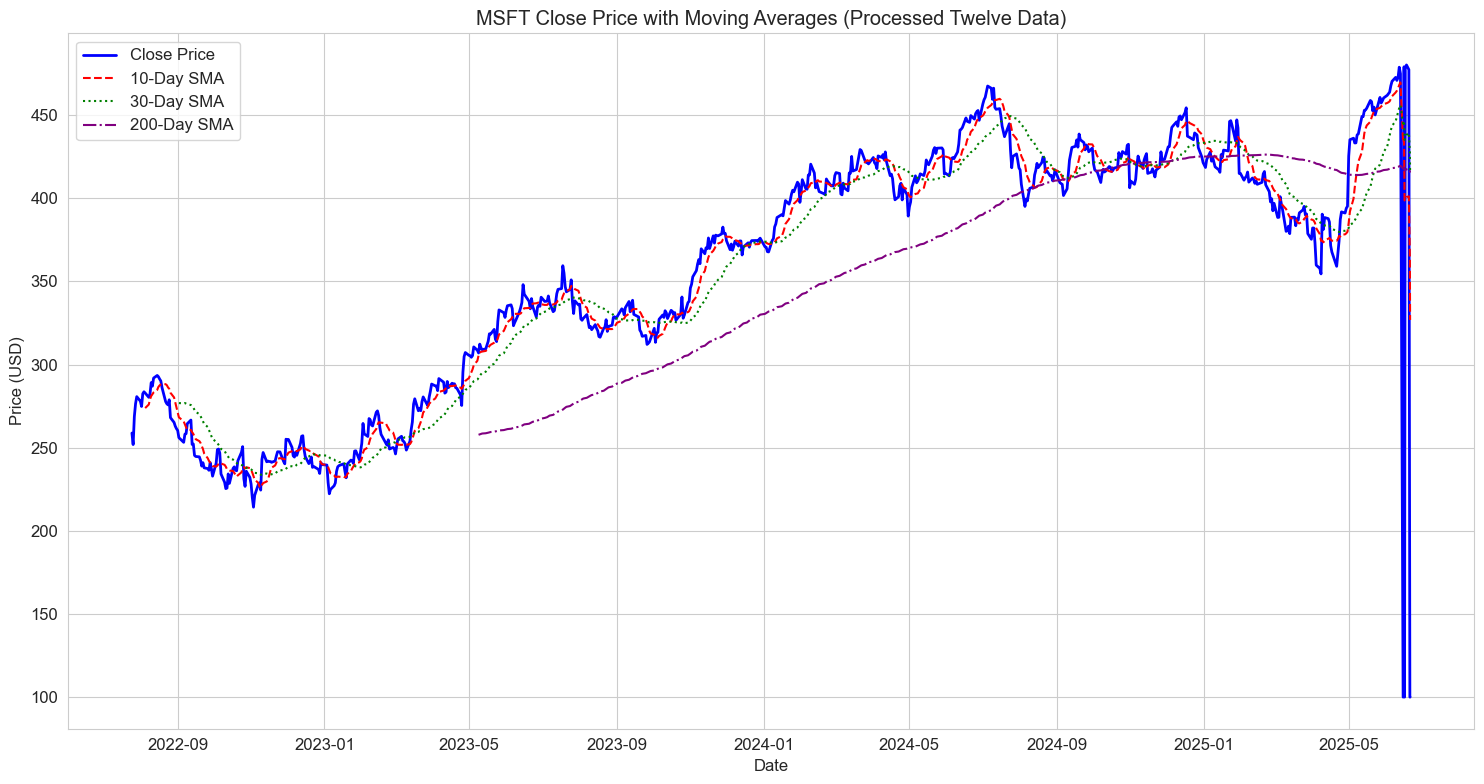

In [388]:
# Cell 9: Calculate and Plot Moving Averages
# Check if the DataFrame is not empty and has a 'close' column
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:

    # --- Calculate Simple Moving Averages (SMA) ---
    # SMA 10-day: Short-term trend
    processed_twelvedata_historical_df['SMA_10'] = processed_twelvedata_historical_df['close'].rolling(window=10).mean()

    # SMA 30-day: Medium-term trend
    processed_twelvedata_historical_df['SMA_30'] = processed_twelvedata_historical_df['close'].rolling(window=30).mean()

    # SMA 200-day: Long-term trend (unchanged)
    processed_twelvedata_historical_df['SMA_200'] = processed_twelvedata_historical_df['close'].rolling(window=200).mean()


    # --- Plotting Close Price with Moving Averages ---
    plt.figure(figsize=(15, 8))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=2)
    
    # Plot SMAs, only if they have enough data points (i.e., not NaN at the beginning)
    if 'SMA_10' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_10'], label='10-Day SMA', color='red', linestyle='--')
    if 'SMA_30' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_30'], label='30-Day SMA', color='green', linestyle=':')
    if 'SMA_200' in processed_twelvedata_historical_df.columns:
        plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_200'], label='200-Day SMA', color='purple', linestyle='-.')

    plt.title(f'{TARGET_SYMBOL} Close Price with Moving Averages (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot Moving Averages. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")




Calculating Relative Strength Index (RSI) for Twelve Data Historical (MSFT)...
Added RSI_14 column.
Last 5 rows with new RSI column:
                                 close     RSI_14
datetime                                         
2025-06-17 00:00:00.000000  478.040009  52.464721
2025-06-18 00:00:00.000000  480.239990  52.545336
2025-06-20 00:00:00.000000  477.399990  52.421742
2025-06-20 19:45:54.218302  100.000000  39.219843
2025-06-21 00:12:30.868634  100.000000  39.219843
Added RSI_14 column.
Last 5 rows with new RSI column:
                                 close     RSI_14
datetime                                         
2025-06-17 00:00:00.000000  478.040009  52.464721
2025-06-18 00:00:00.000000  480.239990  52.545336
2025-06-20 00:00:00.000000  477.399990  52.421742
2025-06-20 19:45:54.218302  100.000000  39.219843
2025-06-21 00:12:30.868634  100.000000  39.219843


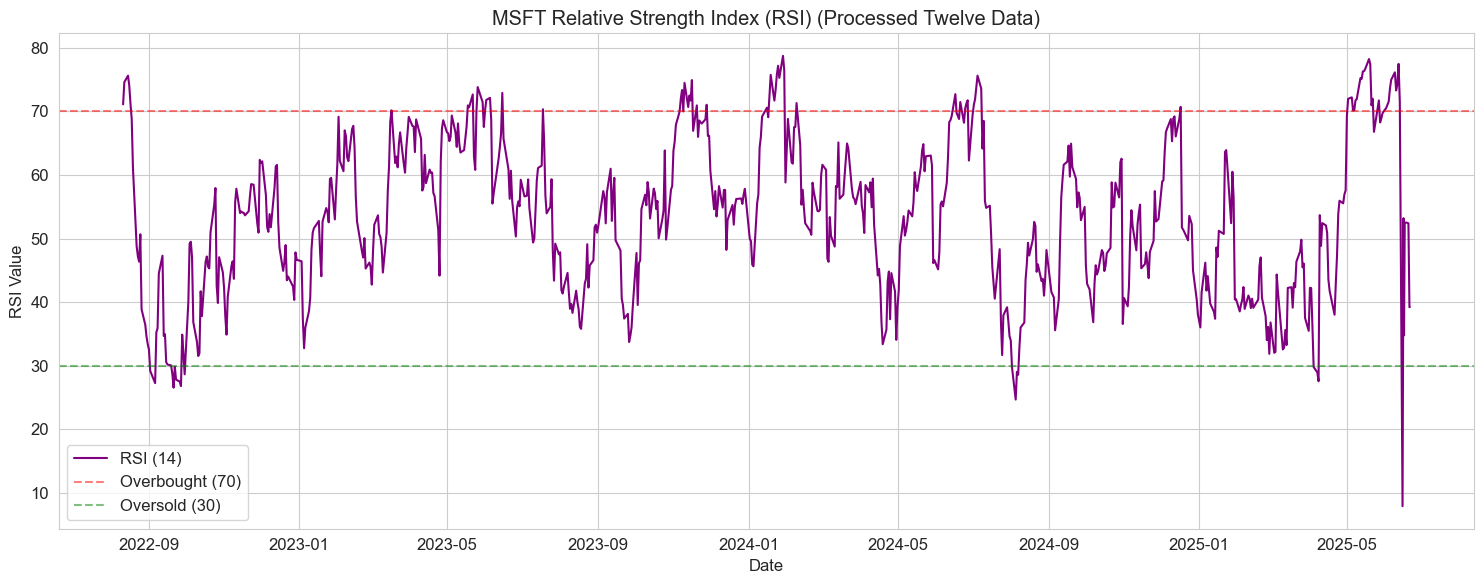

In [389]:
# Cell 10: Calculate and Plot Relative Strength Index (RSI)
# Function to calculate RSI
def calculate_rsi(df, window=14):
    """
    Calculates the Relative Strength Index (RSI) for a given DataFrame.
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Get the difference in price
    delta = df['close'].diff()

    # Get positive and negative gains
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate exponential moving average of gains and losses
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    df[f'RSI_{window}'] = rsi
    return df

# Check if the DataFrame is not empty and has a 'close' column
if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print(f"\nCalculating Relative Strength Index (RSI) for Twelve Data Historical ({TARGET_SYMBOL})...")

    # Calculate RSI with a typical window of 14 days
    processed_twelvedata_historical_df = calculate_rsi(processed_twelvedata_historical_df, window=14)

    print("Added RSI_14 column.")
    print("Last 5 rows with new RSI column:")
    print(processed_twelvedata_historical_df[['close', 'RSI_14']].tail())

    # --- Plotting RSI ---
    plt.figure(figsize=(15, 6))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['RSI_14'], label='RSI (14)', color='purple', linewidth=1.5)
    
    # Add overbought and oversold lines
    plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')

    plt.title(f'{TARGET_SYMBOL} Relative Strength Index (RSI) (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot RSI. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")



Calculating MACD for Twelve Data Historical (MSFT)...
Added MACD_Line, MACD_Signal, and MACD_Histogram columns.
Last 5 rows with new MACD columns:
                                 close  MACD_Line  MACD_Signal  MACD_Histogram
datetime                                                                      
2025-06-17 00:00:00.000000  478.040009 -24.833064    -8.476512      -16.356553
2025-06-18 00:00:00.000000  480.239990 -15.695846    -9.920379       -5.775468
2025-06-20 00:00:00.000000  477.399990  -8.584740    -9.653251        1.068511
2025-06-20 19:45:54.218302  100.000000 -33.021511   -14.326903      -18.694608
2025-06-21 00:12:30.868634  100.000000 -51.790815   -21.819685      -29.971130


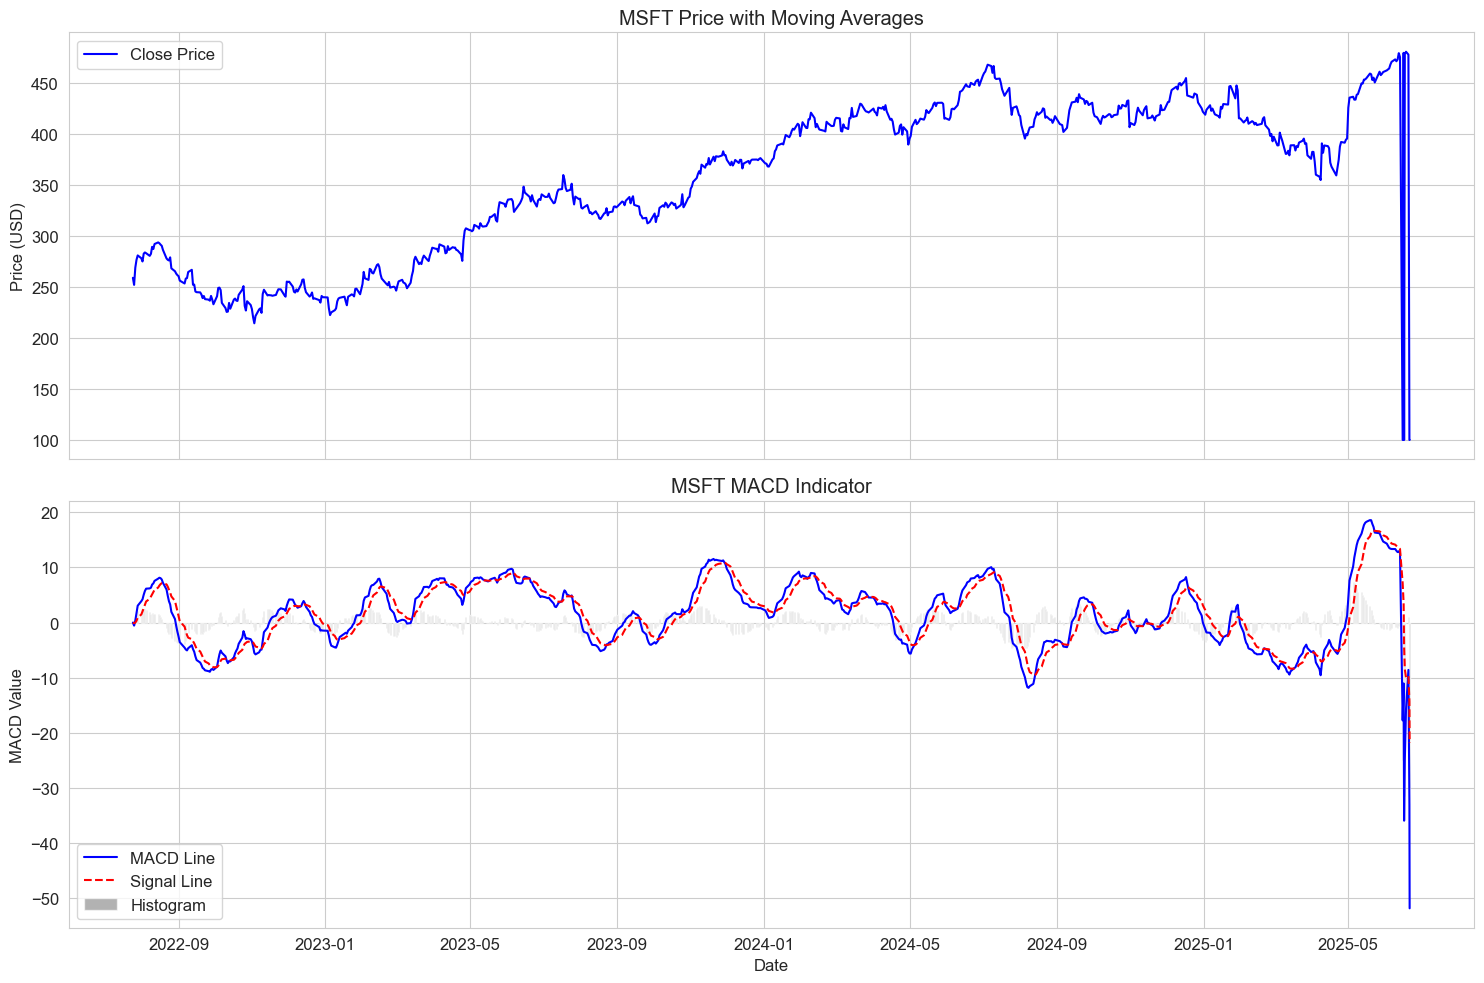

In [390]:
# Cell 11: Calculate and Plot Moving Average Convergence Divergence (MACD)
def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    """
    Calculates MACD (Moving Average Convergence Divergence) and Signal Line.
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Calculate the 12-period EMA
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    # Calculate the 26-period EMA
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()

    # Calculate MACD Line
    macd_line = ema_fast - ema_slow

    # Calculate the 9-period EMA of the MACD Line (Signal Line)
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line

    df[f'MACD_Line'] = macd_line
    df[f'MACD_Signal'] = signal_line
    df[f'MACD_Histogram'] = macd_histogram
    
    return df

if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print(f"\nCalculating MACD for Twelve Data Historical ({TARGET_SYMBOL})...")

    processed_twelvedata_historical_df = calculate_macd(processed_twelvedata_historical_df)

    print("Added MACD_Line, MACD_Signal, and MACD_Histogram columns.")
    print("Last 5 rows with new MACD columns:")
    print(processed_twelvedata_historical_df[['close', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram']].tail())

    # --- Plotting MACD ---
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # Two subplots for price and MACD
    
    # Plotting Price with Moving Averages (reusing earlier MA calculation if available)
    axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=1.5)
    if 'SMA_20' in processed_twelvedata_historical_df.columns:
        axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_20'], label='20-Day SMA', color='red', linestyle='--')
    if 'SMA_50' in processed_twelvedata_historical_df.columns:
        axes[0].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['SMA_50'], label='50-Day SMA', color='green', linestyle=':')
    axes[0].set_title(f'{TARGET_SYMBOL} Price with Moving Averages')
    axes[0].set_ylabel('Price (USD)')
    axes[0].legend()
    axes[0].grid(True)

    # Plotting MACD
    axes[1].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Line'], label='MACD Line', color='blue', linewidth=1.5)
    axes[1].plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Signal'], label='Signal Line', color='red', linestyle='--')
    
    # Plotting MACD Histogram
    axes[1].bar(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['MACD_Histogram'], label='Histogram', color='gray', alpha=0.6)

    axes[1].set_title(f'{TARGET_SYMBOL} MACD Indicator')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('MACD Value')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot MACD. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")




Calculating Bollinger Bands for Twelve Data Historical (MSFT)...
Added BB_Middle, BB_Upper, and BB_Lower columns.
Last 5 rows with new Bollinger Bands columns:
                                 close   BB_Middle    BB_Upper    BB_Lower
datetime                                                                  
2025-06-17 00:00:00.000000  478.040009  429.814998  656.003844  203.626152
2025-06-18 00:00:00.000000  480.239990  431.083998  658.147561  204.020435
2025-06-20 00:00:00.000000  477.399990  432.444998  660.315372  204.574624
2025-06-20 19:45:54.218302  100.000000  414.410498  685.804693  143.016303
2025-06-21 00:12:30.868634  100.000000  396.542498  701.064328   92.020669


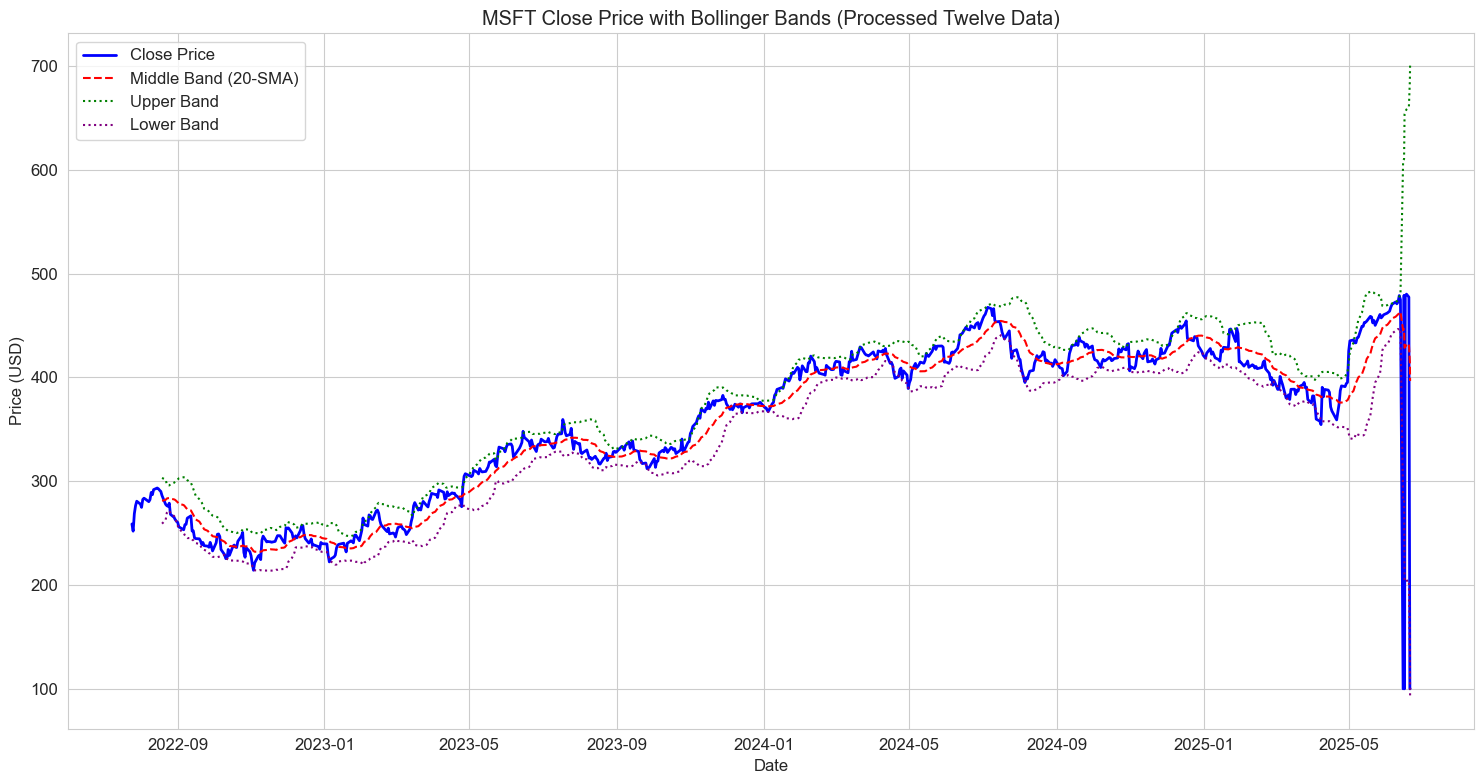

In [391]:
# Cell 12: Calculate and Plot Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    """
    Calculates Bollinger Bands (Middle Band, Upper Band, Lower Band).
    Assumes 'close' price column is available.
    """
    if 'close' not in df.columns:
        return df # Return original DataFrame if close price is missing

    # Middle Band is the N-period Simple Moving Average
    middle_band = df['close'].rolling(window=window).mean()
    # Standard deviation over N periods
    std_dev = df['close'].rolling(window=window).std()

    # Upper and Lower Bands
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)

    df[f'BB_Middle'] = middle_band
    df[f'BB_Upper'] = upper_band
    df[f'BB_Lower'] = lower_band
    
    return df

if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
    print(f"\nCalculating Bollinger Bands for Twelve Data Historical ({TARGET_SYMBOL})...")

    processed_twelvedata_historical_df = calculate_bollinger_bands(processed_twelvedata_historical_df)

    print("Added BB_Middle, BB_Upper, and BB_Lower columns.")
    print("Last 5 rows with new Bollinger Bands columns:")
    print(processed_twelvedata_historical_df[['close', 'BB_Middle', 'BB_Upper', 'BB_Lower']].tail())

    # --- Plotting Bollinger Bands ---
    plt.figure(figsize=(15, 8))
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['close'], label='Close Price', color='blue', linewidth=2)
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Middle'], label='Middle Band (20-SMA)', color='red', linestyle='--')
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Upper'], label='Upper Band', color='green', linestyle=':')
    plt.plot(processed_twelvedata_historical_df.index, processed_twelvedata_historical_df['BB_Lower'], label='Lower Band', color='purple', linestyle=':')

    plt.title(f'{TARGET_SYMBOL} Close Price with Bollinger Bands (Processed Twelve Data)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("\nCannot calculate/plot Bollinger Bands. 'processed_twelvedata_historical_df' is empty or missing 'close' column.")



In [392]:
# Cell 13: Example: Merge Finnhub Quotes with Twelve Data Historical (by date)
# This is a conceptual step if you want to combine data from both sources for analysis.
# Note: Finnhub quotes are usually real-time/intraday, TwelveData historical is typically end-of-day.
# Merging them directly might require careful time alignment and aggregation.

# For a simple demo, let's just show how you'd attempt a merge on date if they aligned.
# In a real scenario, you'd aggregate Finnhub data to daily before merging with daily historical.

if not processed_finnhub_quotes_df.empty and not processed_twelvedata_historical_df.empty:
    # Reset index to merge on date part of timestamp/datetime
    finnhub_daily = processed_finnhub_quotes_df.reset_index().set_index(processed_finnhub_quotes_df.index.normalize())
    twelvedata_daily = processed_twelvedata_historical_df.reset_index().set_index(processed_twelvedata_historical_df.index.normalize())

    # Select a few columns for the merged view
    merged_df = pd.merge(
        finnhub_daily[['close', 'high', 'low', 'open', 'symbol', 'spread']],
        twelvedata_daily[['close', 'volume', 'daily_return', 'symbol']].rename(columns={'close': 'td_close', 'volume': 'td_volume'}),
        left_index=True,
        right_index=True,
        how='inner',
        suffixes=('_finnhub', '_twelvedata')
    )
    print(f"\nExample of Merged Finnhub Quotes & Twelve Data Historical for {TARGET_SYMBOL} (first 5 rows):")
    print(merged_df.head())
    print(f"\nMerged Data Info for {TARGET_SYMBOL}:")
    merged_df.info()
else:
    print("\nNot enough data to demonstrate merging Finnhub and Twelve Data for AAPL.")



Example of Merged Finnhub Quotes & Twelve Data Historical for MSFT (first 5 rows):
            close   high   low  open symbol_finnhub  spread   td_close  \
timestamp                                                                
2025-06-16  100.0  102.0  98.0  99.0           MSFT     4.0  479.14001   
2025-06-16  100.0  102.0  98.0  99.0           MSFT     4.0  100.00000   
2025-06-20  100.0  102.0  98.0  99.0           MSFT     4.0  477.39999   
2025-06-20  100.0  102.0  98.0  99.0           MSFT     4.0  100.00000   
2025-06-21  100.0  102.0  98.0  99.0           MSFT     4.0  100.00000   

            td_volume  daily_return symbol_twelvedata  
timestamp                                              
2025-06-16   15626100      0.008801              MSFT  
2025-06-16    1000000           NaN              MSFT  
2025-06-20   37468700     -0.005914              MSFT  
2025-06-20    1000000           NaN              MSFT  
2025-06-21    1000000           NaN              MSFT  

Merg


Identifying simple trading signals for MSFT...
  SMA Crossover signals calculated (1=Buy, -1=Sell, using 10/30).
  RSI Overbought/Oversold signals calculated (1=Buy, -1=Sell, thresholds 40/60).
  Combined signals (AND) calculated (1=Buy, -1=Sell, thresholds 40/60, using 10/30).
  Combined_Signal_OR (OR logic) calculated (1=Buy, -1=Sell, thresholds 40/60, using 10/30).
  Combined_Signal_WINDOW (windowed AND, ±3 days) calculated (1=Buy, -1=Sell, using 10/30).

Signal counts for Combined_Signal_WINDOW:
Combined_Signal_WINDOW
 0    731
 1      2
-1      1
Name: count, dtype: int64
  Combined_Signal_WINDOW (windowed AND, ±3 days) calculated (1=Buy, -1=Sell, using 10/30).

Signal counts for Combined_Signal_WINDOW:
Combined_Signal_WINDOW
 0    731
 1      2
-1      1
Name: count, dtype: int64


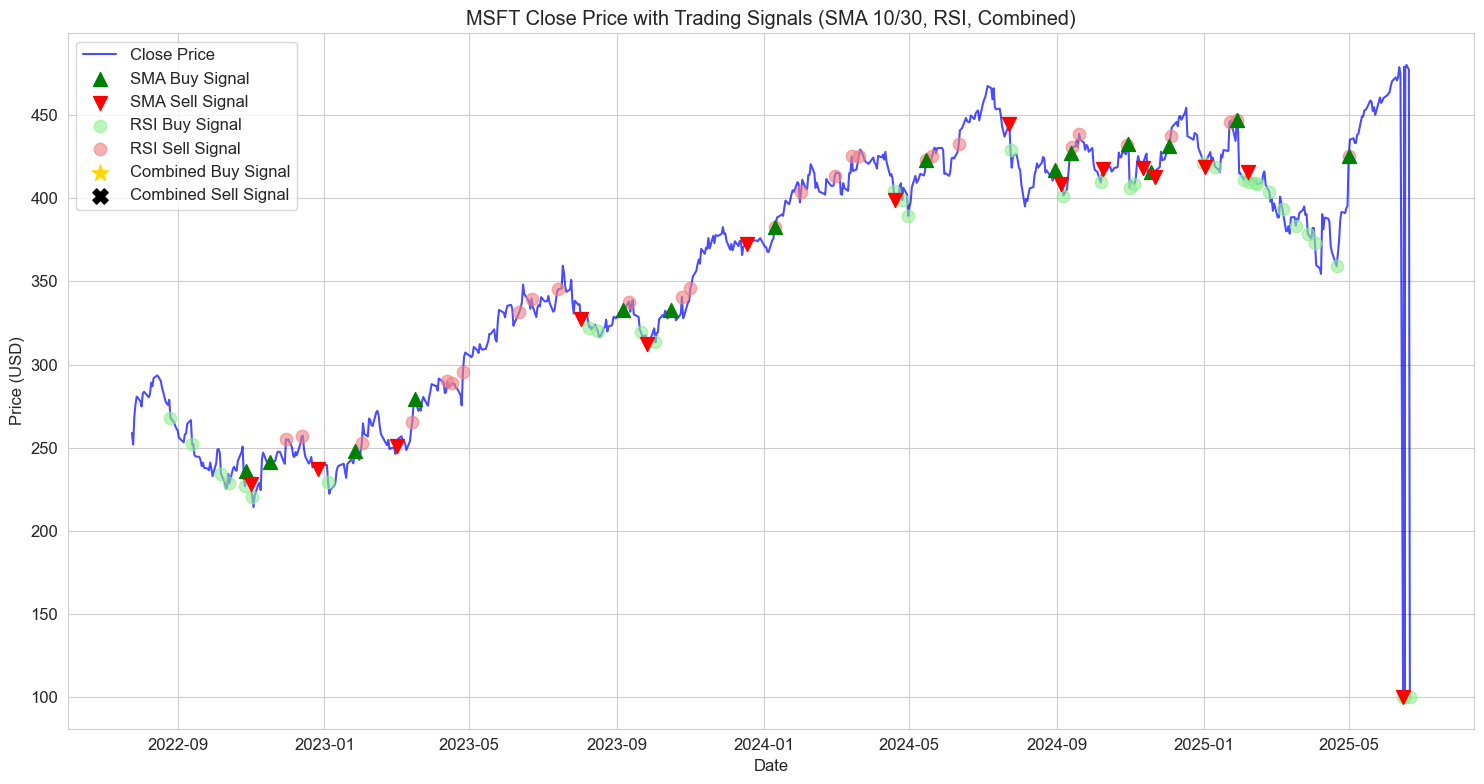

In [393]:
# Cell 14: Identify Simple Trading Signals (with Combined Signal)
# This cell uses the previously calculated indicators to generate basic buy/sell signals.
# This is a starting point; real trading strategies are far more complex.

if not processed_twelvedata_historical_df.empty:
    print(f"\nIdentifying simple trading signals for {TARGET_SYMBOL}...")

    df_signals = processed_twelvedata_historical_df.copy() # Work on a copy to avoid SettingWithCopyWarning

    # --- SMA Crossover Signal ---
    df_signals['SMA_Crossover_Signal'] = 0 # Default to no signal
    if 'SMA_10' in df_signals.columns and 'SMA_30' in df_signals.columns:
        df_signals['SMA_Diff'] = df_signals['SMA_10'] - df_signals['SMA_30']
        df_signals['SMA_Crossover'] = (df_signals['SMA_Diff'].shift(1) < 0) & (df_signals['SMA_Diff'] > 0) # Buy signal
        df_signals['SMA_Crossunder'] = (df_signals['SMA_Diff'].shift(1) > 0) & (df_signals['SMA_Diff'] < 0) # Sell signal
        df_signals.loc[df_signals['SMA_Crossover'], 'SMA_Crossover_Signal'] = 1 # Buy signal
        df_signals.loc[df_signals['SMA_Crossunder'], 'SMA_Crossover_Signal'] = -1 # Sell signal
        df_signals.drop(columns=['SMA_Diff', 'SMA_Crossover', 'SMA_Crossunder'], inplace=True)
        print("  SMA Crossover signals calculated (1=Buy, -1=Sell, using 10/30).")

    # --- RSI Overbought/Oversold Signal (looser: 40/60) ---
    df_signals['RSI_Signal'] = 0 # Default to no signal
    if 'RSI_14' in df_signals.columns:
        df_signals['RSI_Buy_Cross'] = (df_signals['RSI_14'].shift(1) > 40) & (df_signals['RSI_14'] <= 40)
        df_signals['RSI_Sell_Cross'] = (df_signals['RSI_14'].shift(1) < 60) & (df_signals['RSI_14'] >= 60)
        df_signals.loc[df_signals['RSI_Buy_Cross'], 'RSI_Signal'] = 1 # Buy signal
        df_signals.loc[df_signals['RSI_Sell_Cross'], 'RSI_Signal'] = -1 # Sell signal
        df_signals.drop(columns=['RSI_Buy_Cross', 'RSI_Sell_Cross'], inplace=True)
        print("  RSI Overbought/Oversold signals calculated (1=Buy, -1=Sell, thresholds 40/60).")

    # --- Combined Signal (AND) ---
    df_signals['Combined_Signal'] = 0
    if 'SMA_Crossover_Signal' in df_signals.columns and 'RSI_14' in df_signals.columns:
        buy_condition = (df_signals['SMA_Crossover_Signal'] == 1) & (df_signals['RSI_14'] <= 40)
        sell_condition = (df_signals['SMA_Crossover_Signal'] == -1) & (df_signals['RSI_14'] >= 60)
        df_signals.loc[buy_condition, 'Combined_Signal'] = 1
        df_signals.loc[sell_condition, 'Combined_Signal'] = -1
        print("  Combined signals (AND) calculated (1=Buy, -1=Sell, thresholds 40/60, using 10/30).")

    # --- Combined Signal OR (triggers if either SMA or RSI signal fires) ---
    df_signals['Combined_Signal_OR'] = 0
    df_signals.loc[(df_signals['SMA_Crossover_Signal'] == 1) | (df_signals['RSI_Signal'] == 1), 'Combined_Signal_OR'] = 1
    df_signals.loc[(df_signals['SMA_Crossover_Signal'] == -1) | (df_signals['RSI_Signal'] == -1), 'Combined_Signal_OR'] = -1
    print("  Combined_Signal_OR (OR logic) calculated (1=Buy, -1=Sell, thresholds 40/60, using 10/30).")

    # --- Combined Signal (Windowed AND, ±3 days) ---
    df_signals['Combined_Signal_WINDOW'] = 0
    window = 3
    sma_buy_idx = df_signals.index[df_signals['SMA_Crossover_Signal'] == 1].tolist()
    rsi_buy_idx = df_signals.index[df_signals['RSI_14'] <= 40].tolist()
    for idx in sma_buy_idx:
        window_range = df_signals.index.get_loc(idx)
        start = max(0, window_range - window)
        end = min(len(df_signals) - 1, window_range + window)
        window_indices = df_signals.index[start:end+1]
        if any(i in rsi_buy_idx for i in window_indices):
            df_signals.at[idx, 'Combined_Signal_WINDOW'] = 1
    sma_sell_idx = df_signals.index[df_signals['SMA_Crossover_Signal'] == -1].tolist()
    rsi_sell_idx = df_signals.index[df_signals['RSI_14'] >= 60].tolist()
    for idx in sma_sell_idx:
        window_range = df_signals.index.get_loc(idx)
        start = max(0, window_range - window)
        end = min(len(df_signals) - 1, window_range + window)
        window_indices = df_signals.index[start:end+1]
        if any(i in rsi_sell_idx for i in window_indices):
            df_signals.at[idx, 'Combined_Signal_WINDOW'] = -1
    print("  Combined_Signal_WINDOW (windowed AND, ±3 days) calculated (1=Buy, -1=Sell, using 10/30).")

    # --- Diagnostic: Show signal counts ---
    print("\nSignal counts for Combined_Signal_WINDOW:")
    print(df_signals['Combined_Signal_WINDOW'].value_counts())

    # --- Plotting Signals on Price Chart (Optional, can be dense) ---
    plt.figure(figsize=(15, 8))
    plt.plot(df_signals.index, df_signals['close'], label='Close Price', color='blue', linewidth=1.5, alpha=0.7)
    plt.scatter(df_signals.index[df_signals['SMA_Crossover_Signal'] == 1], 
                df_signals['close'][df_signals['SMA_Crossover_Signal'] == 1], 
                marker='^', color='green', s=100, label='SMA Buy Signal', zorder=5)
    plt.scatter(df_signals.index[df_signals['SMA_Crossover_Signal'] == -1], 
                df_signals['close'][df_signals['SMA_Crossover_Signal'] == -1], 
                marker='v', color='red', s=100, label='SMA Sell Signal', zorder=5)
    plt.scatter(df_signals.index[df_signals['RSI_Signal'] == 1], 
                df_signals['close'][df_signals['RSI_Signal'] == 1], 
                marker='o', color='lightgreen', s=80, alpha=0.6, label='RSI Buy Signal', zorder=4)
    plt.scatter(df_signals.index[df_signals['RSI_Signal'] == -1], 
                df_signals['close'][df_signals['RSI_Signal'] == -1], 
                marker='o', color='lightcoral', s=80, alpha=0.6, label='RSI Sell Signal', zorder=4)
    plt.scatter(df_signals.index[df_signals['Combined_Signal'] == 1], 
                df_signals['close'][df_signals['Combined_Signal'] == 1], 
                marker='*', color='gold', s=150, label='Combined Buy Signal', zorder=6)
    plt.scatter(df_signals.index[df_signals['Combined_Signal'] == -1], 
                df_signals['close'][df_signals['Combined_Signal'] == -1], 
                marker='X', color='black', s=120, label='Combined Sell Signal', zorder=6)
    plt.title(f'{TARGET_SYMBOL} Close Price with Trading Signals (SMA 10/30, RSI, Combined)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nCannot identify trading signals. 'processed_twelvedata_historical_df' is empty.")


      Initial Capital  Final Portfolio Value  Total Trades Executed  \
1043            10000           25285.470223                     23   
1041            10000           19433.510137                     23   
1039            10000           14338.290060                     23   
1057            10000           14308.110054                     21   
1001            10000           25179.020190                     23   
1061            10000           25171.880213                     21   
997             10000           14301.180043                     23   
999             10000           19356.160117                     23   
1059            10000           19356.780129                     21   
995             10000           25153.550190                     23   
1051            10000           14293.830045                     22   
991             10000           14292.690043                     23   
993             10000           19339.180117                     23   
983   

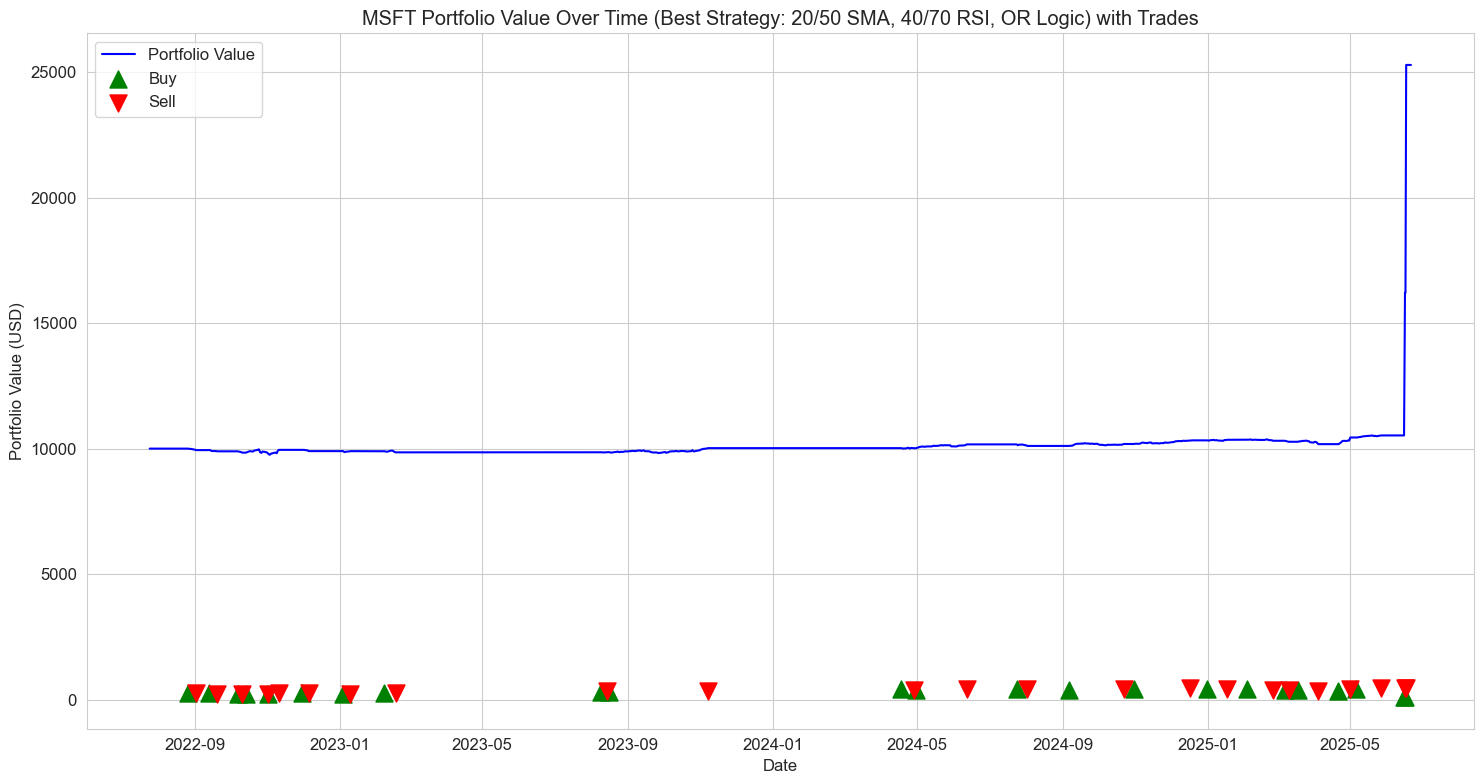

In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Backtest Configuration ---
INITIAL_CAPITAL = 10000
STOP_LOSS_PERCENT = 0.05   # 5% stop loss
TAKE_PROFIT_PERCENT = 0.10 # 10% take profit
POSITION_SIZE_PERCENT = 0.25 # 25% of capital per trade (configurable)
# You can change these values here to experiment with different parameters.

# --- Helper Functions for Indicator Calculations ---
def calculate_sma(df, short_period, long_period):
    df = df.copy()
    df[f'SMA_{short_period}'] = df['close'].rolling(window=short_period).mean()
    df[f'SMA_{long_period}'] = df['close'].rolling(window=long_period).mean()
    return df

def calculate_rsi(df, window=14):
    df = df.copy()
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df[f'RSI_{window}'] = rsi
    return df

def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9):
    df = df.copy()
    ema_fast = df['close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow_period, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    df['MACD_Line'] = macd_line
    df['MACD_Signal'] = signal_line
    df['MACD_Histogram'] = macd_histogram
    return df

def calculate_bollinger_bands(df, window=20, num_std_dev=2):
    df = df.copy()
    middle_band = df['close'].rolling(window=window).mean()
    std_dev = df['close'].rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)
    df['BB_Middle'] = middle_band
    df['BB_Upper'] = upper_band
    df['BB_Lower'] = lower_band
    return df

def calculate_signals(df, sma_short, sma_long, rsi_oversold, rsi_overbought):
    df = df.copy()
    # SMA Crossover
    df['SMA_Crossover_Signal'] = 0
    if f'SMA_{sma_short}' in df.columns and f'SMA_{sma_long}' in df.columns:
        df['SMA_Diff'] = df[f'SMA_{sma_short}'] - df[f'SMA_{sma_long}']
        df['SMA_Crossover'] = (df['SMA_Diff'].shift(1) < 0) & (df['SMA_Diff'] > 0)
        df['SMA_Crossunder'] = (df['SMA_Diff'].shift(1) > 0) & (df['SMA_Diff'] < 0)
        df.loc[df['SMA_Crossover'], 'SMA_Crossover_Signal'] = 1
        df.loc[df['SMA_Crossunder'], 'SMA_Crossover_Signal'] = -1
        df.drop(columns=['SMA_Diff', 'SMA_Crossover', 'SMA_Crossunder'], inplace=True)
    # RSI Signal
    df['RSI_Signal'] = 0
    if 'RSI_14' in df.columns:
        df['RSI_Buy_Cross'] = (df['RSI_14'].shift(1) > rsi_oversold) & (df['RSI_14'] <= rsi_oversold)
        df['RSI_Sell_Cross'] = (df['RSI_14'].shift(1) < rsi_overbought) & (df['RSI_14'] >= rsi_overbought)
        df.loc[df['RSI_Buy_Cross'], 'RSI_Signal'] = 1
        df.loc[df['RSI_Sell_Cross'], 'RSI_Signal'] = -1
        df.drop(columns=['RSI_Buy_Cross', 'RSI_Sell_Cross'], inplace=True)
    # Combined Signals
    df['Combined_Signal'] = 0
    if 'SMA_Crossover_Signal' in df.columns and 'RSI_14' in df.columns:
        buy_condition = (df['SMA_Crossover_Signal'] == 1) & (df['RSI_14'] <= rsi_oversold)
        sell_condition = (df['SMA_Crossover_Signal'] == -1) & (df['RSI_14'] >= rsi_overbought)
        df.loc[buy_condition, 'Combined_Signal'] = 1
        df.loc[sell_condition, 'Combined_Signal'] = -1
    df['Combined_Signal_OR'] = 0
    df.loc[(df['SMA_Crossover_Signal'] == 1) | (df['RSI_Signal'] == 1), 'Combined_Signal_OR'] = 1
    df.loc[(df['SMA_Crossover_Signal'] == -1) | (df['RSI_Signal'] == -1), 'Combined_Signal_OR'] = -1
    return df

# --- Backtest Function ---
def run_backtest(df_signals, initial_capital, stop_loss_percent, take_profit_percent, position_size_percent, symbol_name, sma_short, sma_long, rsi_oversold, rsi_overbought, use_or_logic=False):
    df = df_signals.copy()
    signal_col = 'Combined_Signal_OR' if use_or_logic else 'Combined_Signal'
    shares_held = 0
    capital = initial_capital
    trade_details = []
    current_buy_price = 0
    portfolio_value = [initial_capital]
    daily_returns_strategy = []
    for i in range(1, len(df)):
        current_close = df['close'].iloc[i]
        current_date = df.index[i]
        current_day_portfolio_value = capital + (shares_held * current_close) if shares_held > 0 else capital
        if len(portfolio_value) > 0 and portfolio_value[-1] != 0:
            daily_return_for_day = (current_day_portfolio_value / portfolio_value[-1]) - 1
            daily_returns_strategy.append(daily_return_for_day)
        else:
            daily_returns_strategy.append(0)
        # Stop-Loss/Take-Profit
        if shares_held > 0 and current_buy_price > 0:
            stop_loss_price = current_buy_price * (1 - stop_loss_percent)
            take_profit_price = current_buy_price * (1 + take_profit_percent)
            if current_close <= stop_loss_price:
                trade_profit = (current_close - current_buy_price) * shares_held
                capital += (shares_held * current_close)
                trade_details.append({'date': current_date, 'type': 'Sell (SL)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
                shares_held = 0
                current_buy_price = 0
            elif current_close >= take_profit_price:
                trade_profit = (current_close - current_buy_price) * shares_held
                capital += (shares_held * current_close)
                trade_details.append({'date': current_date, 'type': 'Sell (TP)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
                shares_held = 0
                current_buy_price = 0
        # Signal logic
        signal = df[signal_col].iloc[i]
        if signal == 1 and shares_held == 0:
            capital_to_allocate = capital * position_size_percent
            shares_to_buy = int(capital_to_allocate / current_close)
            if shares_to_buy == 0 and capital >= current_close:
                shares_to_buy = 1
            if shares_to_buy > 0:
                cost = shares_to_buy * current_close
                capital -= cost
                shares_held = shares_to_buy
                current_buy_price = current_close
                trade_details.append({'date': current_date, 'type': 'Buy', 'price': current_close, 'shares': shares_held, 'profit_loss': -cost})
        elif signal == -1 and shares_held > 0:
            trade_profit = (current_close - current_buy_price) * shares_held
            capital += (shares_held * current_close)
            trade_details.append({'date': current_date, 'type': 'Sell (SIGNAL)', 'price': current_close, 'shares': shares_held, 'profit_loss': trade_profit})
            shares_held = 0
            current_buy_price = 0
        portfolio_value.append(capital + (shares_held * current_close))
    # Final close
    if shares_held > 0:
        final_close = df['close'].iloc[-1]
        trade_profit = (final_close - current_buy_price) * shares_held
        capital += (shares_held * final_close)
        trade_details.append({'date': df.index[-1], 'type': 'Sell (Final)', 'price': final_close, 'shares': shares_held, 'profit_loss': trade_profit})
        shares_held = 0
    final_portfolio_value = capital
    total_return_usd = final_portfolio_value - initial_capital
    total_return_percent = (total_return_usd / initial_capital) * 100
    winning_trades = [t for t in trade_details if t['type'].startswith('Sell') and t['profit_loss'] > 0]
    losing_trades = [t for t in trade_details if t['type'].startswith('Sell') and t['profit_loss'] < 0]
    total_trades_executed = len(winning_trades) + len(losing_trades)
    win_rate = (len(winning_trades) / total_trades_executed * 100) if total_trades_executed > 0 else 0
    avg_win = (sum(t['profit_loss'] for t in winning_trades) / len(winning_trades)) if winning_trades else 0
    avg_loss = (sum(t['profit_loss'] for t in losing_trades) / len(losing_trades)) if losing_trades else 0
    if len(daily_returns_strategy) > 0:
        daily_returns_series = pd.Series(daily_returns_strategy)
        cumulative_returns = (1 + daily_returns_series).cumprod()
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - running_max) / running_max
        max_drawdown = drawdown.min() * 100
        annualization_factor = np.sqrt(252)
        sharpe_ratio = (daily_returns_series.mean() / daily_returns_series.std()) * annualization_factor if daily_returns_series.std() != 0 else None
        downside_returns = daily_returns_series[daily_returns_series < 0]
        if not downside_returns.empty and downside_returns.std() != 0:
            downside_deviation = downside_returns.std()
            annualized_downside_deviation = downside_deviation * annualization_factor
            sortino_ratio = (daily_returns_series.mean() / annualized_downside_deviation) * annualization_factor
        else:
            sortino_ratio = None
    else:
        max_drawdown = None
        sharpe_ratio = None
        sortino_ratio = None
    results_summary = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_portfolio_value,
        'Total Trades Executed': total_trades_executed,
        'Winning Trades': len(winning_trades),
        'Losing Trades': len(losing_trades),
        'Win Rate (%)': win_rate,
        'Average Win (USD)': avg_win,
        'Average Loss (USD)': avg_loss,
        'Total Return (USD)': total_return_usd,
        'Total Return (%)': total_return_percent,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio (Annualized)': sharpe_ratio,
        'Sortino Ratio (Annualized)': sortino_ratio
    }
    return results_summary, trade_details, portfolio_value

# --- Parameter Grids ---
sma_short_periods = [10, 20, 30]
sma_long_periods = [30, 50, 60]
rsi_oversold_thresholds = [30, 40]
rsi_overbought_thresholds = [60, 70]
sl_percentages = [0.03, 0.05, 0.07]
tp_percentages = [0.08, 0.10, 0.12]
position_sizes = [0.05, 0.10, 0.15]
logic_types = [False, True]  # False=AND, True=OR

all_optimization_results = []

for s_short in sma_short_periods:
    for s_long in sma_long_periods:
        if s_short >= s_long:
            continue
        for rsi_os in rsi_oversold_thresholds:
            for rsi_ob in rsi_overbought_thresholds:
                for sl_percent in sl_percentages:
                    for tp_percent in tp_percentages:
                        for pos_size in position_sizes:
                            for use_or_logic in logic_types:
                                if not processed_twelvedata_historical_df.empty and 'close' in processed_twelvedata_historical_df.columns:
                                    df = processed_twelvedata_historical_df.copy()
                                    df = calculate_sma(df, s_short, s_long)
                                    df = calculate_rsi(df, window=14)
                                    df = calculate_macd(df)
                                    df = calculate_bollinger_bands(df)
                                    df = calculate_signals(df, s_short, s_long, rsi_os, rsi_ob)
                                    current_results, _, _ = run_backtest(
                                        df_signals=df,
                                        initial_capital=INITIAL_CAPITAL,
                                        stop_loss_percent=sl_percent,
                                        take_profit_percent=tp_percent,
                                        position_size_percent=pos_size,
                                        symbol_name=TARGET_SYMBOL,
                                        sma_short=s_short,
                                        sma_long=s_long,
                                        rsi_oversold=rsi_os,
                                        rsi_overbought=rsi_ob,
                                        use_or_logic=use_or_logic
                                    )
                                    current_results['SMA Short'] = s_short
                                    current_results['SMA Long'] = s_long
                                    current_results['RSI Oversold'] = rsi_os
                                    current_results['RSI Overbought'] = rsi_ob
                                    current_results['SL %'] = sl_percent
                                    current_results['TP %'] = tp_percent
                                    current_results['Position Size %'] = pos_size
                                    current_results['Logic'] = 'OR' if use_or_logic else 'AND'
                                    all_optimization_results.append(current_results)

# --- Present Results ---
results_df = pd.DataFrame(all_optimization_results)
results_df_sorted = results_df.sort_values(by=['Sharpe Ratio (Annualized)', 'Total Return (%)'], ascending=[False, False])

# Display top 20 strategies
print(results_df_sorted.head(20))

# --- Identify and Visualize Best Strategy ---
if not results_df_sorted.empty:
    best_strategy_params = results_df_sorted.iloc[0]
    print("\n--- Best Performing Strategy Parameters ---")
    print(best_strategy_params)

    # Extract best parameters
    best_s_short = int(best_strategy_params['SMA Short'])
    best_s_long = int(best_strategy_params['SMA Long'])
    best_rsi_os = int(best_strategy_params['RSI Oversold'])
    best_rsi_ob = int(best_strategy_params['RSI Overbought'])
    best_sl_percent = float(best_strategy_params['SL %'])
    best_tp_percent = float(best_strategy_params['TP %'])
    best_pos_size = float(best_strategy_params['Position Size %'])
    best_use_or_logic = True if best_strategy_params['Logic'] == 'OR' else False

    # Re-calculate indicators and signals for the best strategy
    df_for_best_plot = processed_twelvedata_historical_df.copy()
    df_for_best_plot = calculate_sma(df_for_best_plot, best_s_short, best_s_long)
    df_for_best_plot = calculate_rsi(df_for_best_plot, window=14)
    df_for_best_plot = calculate_macd(df_for_best_plot)
    df_for_best_plot = calculate_bollinger_bands(df_for_best_plot)
    df_for_best_plot = calculate_signals(df_for_best_plot, best_s_short, best_s_long, best_rsi_os, best_rsi_ob)

    # Re-run backtest for the best strategy
    best_summary, best_trade_details, best_portfolio_value = run_backtest(
        df_signals=df_for_best_plot,
        initial_capital=INITIAL_CAPITAL,
        stop_loss_percent=best_sl_percent,
        take_profit_percent=best_tp_percent,
        position_size_percent=best_pos_size,
        symbol_name=TARGET_SYMBOL,
        sma_short=best_s_short,
        sma_long=best_s_long,
        rsi_oversold=best_rsi_os,
        rsi_overbought=best_rsi_ob,
        use_or_logic=best_use_or_logic
    )

    # --- Plotting Best Strategy Portfolio Value with Trades ---
    plt.figure(figsize=(15, 8))
    # Ensure x and y are the same length for plotting
    plt.plot(df_for_best_plot.index, best_portfolio_value[:len(df_for_best_plot.index)], label='Portfolio Value', color='blue')

    buy_dates = [t['date'] for t in best_trade_details if t['type'] == 'Buy']
    buy_prices = [t['price'] for t in best_trade_details if t['type'] == 'Buy']
    sell_dates = [t['date'] for t in best_trade_details if t['type'].startswith('Sell')]
    sell_prices = [t['price'] for t in best_trade_details if t['type'].startswith('Sell')]

    plt.scatter(buy_dates, buy_prices, marker='^', color='green', s=150, label='Buy', zorder=5)
    plt.scatter(sell_dates, sell_prices, marker='v', color='red', s=150, label='Sell', zorder=5)

    plot_title_logic = 'OR' if best_use_or_logic else 'AND'
    plt.title(f'{TARGET_SYMBOL} Portfolio Value Over Time (Best Strategy: {best_s_short}/{best_s_long} SMA, {best_rsi_os}/{best_rsi_ob} RSI, {plot_title_logic} Logic) with Trades')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo strategies found to optimize.")


In [ ]:
# Parameter Sweep: Backtest for different stop-loss/take-profit thresholds
import itertools
sweep_results = []
sl_values = [0.03, 0.05, 0.07]
tp_values = [0.07, 0.10, 0.15]
for sl, tp in itertools.product(sl_values, tp_values):
    capital = 10000
    shares = 0
    buy_price = 0
    trade_log = []
    for i in range(1, len(df_signals)):
        close = df_signals['close'].iloc[i]
        signal = df_signals['Combined_Signal_OR'].iloc[i]
        if shares > 0:
            if close <= buy_price * (1 - sl):
                capital += shares * close
                trade_log.append({'type': 'Sell (SL)', 'price': close})
                shares = 0
            elif close >= buy_price * (1 + tp):
                capital += shares * close
                trade_log.append({'type': 'Sell (TP)', 'price': close})
                shares = 0
        if signal == 1 and shares == 0:
            shares = int(capital / close)
            if shares > 0:
                capital -= shares * close
                buy_price = close
                trade_log.append({'type': 'Buy', 'price': close})
        elif signal == -1 and shares > 0:
            capital += shares * close
            trade_log.append({'type': 'Sell', 'price': close})
            shares = 0
    if shares > 0:
        capital += shares * df_signals['close'].iloc[-1]
    total_return = (capital - 10000) / 10000 * 100
    sweep_results.append({'Stop Loss %': sl*100, 'Take Profit %': tp*100, 'Final Value': capital, 'Total Return %': total_return, 'Trades': len(trade_log)})
sweep_df = pd.DataFrame(sweep_results)
display(sweep_df.sort_values('Total Return %', ascending=False))

,Stop Loss %,Take Profit %,Final Value,Total Return %,Trades
3,5.0,7.0,75101.807611,651.018076,59
2,3.0,15.0,71250.307931,612.503079,57
0,3.0,7.0,70774.628136,607.746281,63
6,7.0,7.0,69350.578531,593.505785,55
8,7.0,15.0,67965.088382,579.650884,49
4,5.0,10.0,67907.487824,579.074878,55
5,5.0,15.0,67460.017415,574.600174,53
1,3.0,10.0,66449.548951,564.495490,59
7,7.0,10.0,63653.899351,536.538994,51


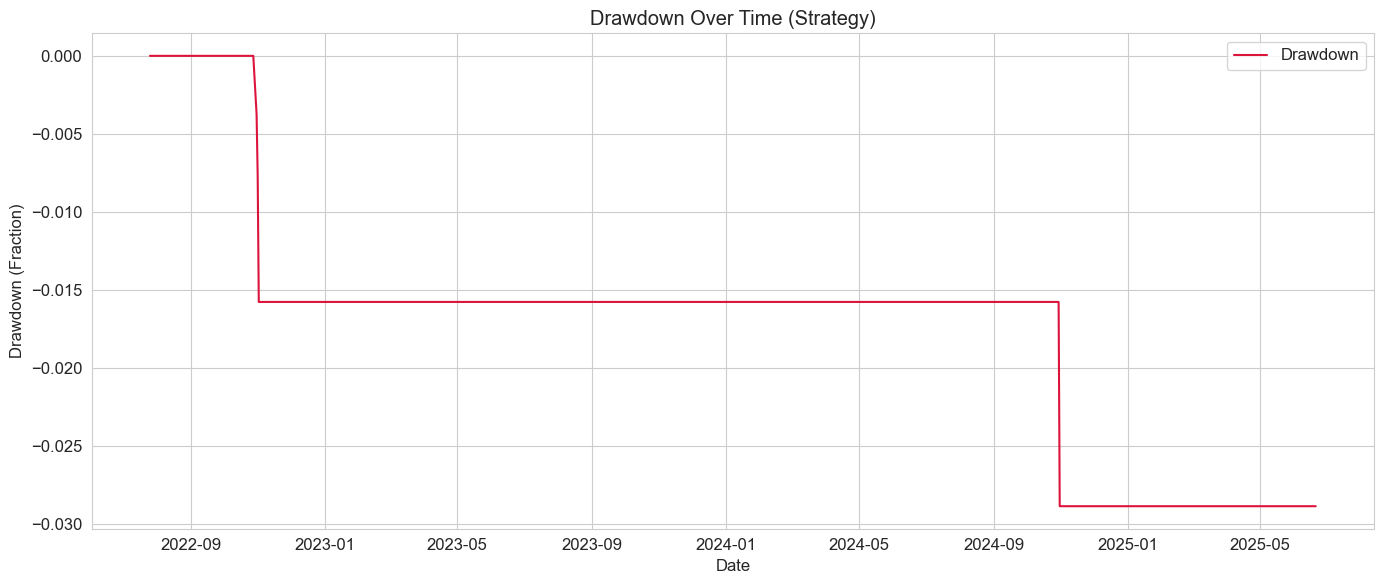

In [ ]:
# Plot drawdowns
daily_returns_series = pd.Series(daily_returns_strategy)
cumulative_returns = (1 + daily_returns_series).cumprod()
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
plt.figure(figsize=(14, 6))
plt.plot(df_signals.index[1:], drawdown, label='Drawdown', color='crimson')
plt.title('Drawdown Over Time (Strategy)')
plt.xlabel('Date')
plt.ylabel('Drawdown (Fraction)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

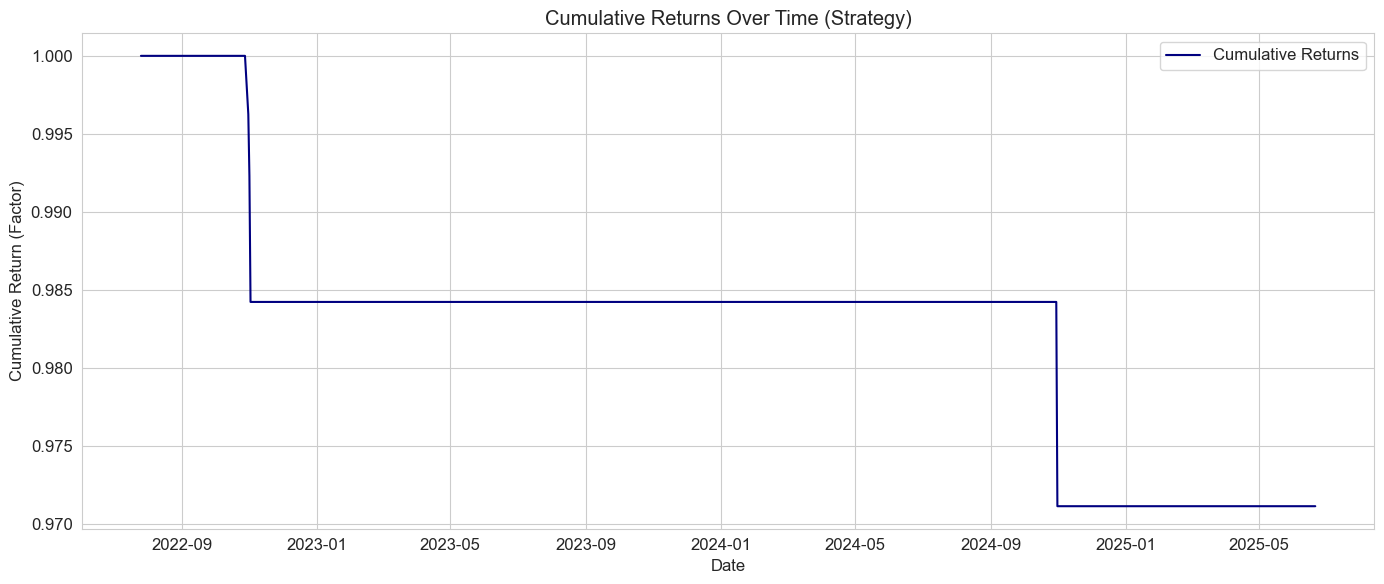

In [ ]:
# Plot cumulative returns
daily_returns_series = pd.Series(daily_returns_strategy)
cumulative_returns = (1 + daily_returns_series).cumprod()
plt.figure(figsize=(14, 6))
plt.plot(df_signals.index[1:], cumulative_returns, label='Cumulative Returns', color='navy')
plt.title('Cumulative Returns Over Time (Strategy)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Factor)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Display trade metrics as a formatted table
metrics_df = pd.DataFrame([results_summary]).T
metrics_df.columns = ['Value']
display(metrics_df)

,Value
Initial Capital,10000.000000
Final Portfolio Value,9711.400150
Total Trades Executed,2.000000
Winning Trades,0.000000
Losing Trades,2.000000
Win Rate (%),0.000000
Average Win (USD),0.000000
Average Loss (USD),-144.299925
Total Return (USD),-288.599850
Total Return (%),-2.885998


In [ ]:
# Export trade log to CSV
import os
trade_log_df = pd.DataFrame(trade_details)
trade_log_path = os.path.join(os.getcwd(), 'trade_log.csv')
trade_log_df.to_csv(trade_log_path, index=False)
print(f"Trade log exported to: {trade_log_path}")

Trade log exported to: c:\Users\user\OneDrive\Desktop\Algotrading_Bot\trade_log.csv


In [ ]:
# Cell 16: Example: Merge Finnhub Quotes with Twelve Data Historical (by date)
# This is a conceptual step if you want to combine data from both sources for analysis.
# Note: Finnhub quotes are usually real-time/intraday, TwelveData historical is typically end-of-day.
# Merging them directly might require careful time alignment and aggregation.

# For a simple demo, let's just show how you'd attempt a merge on date if they aligned.
# In a real scenario, you'd aggregate Finnhub data to daily before merging with daily historical.

if not processed_finnhub_quotes_df.empty and not processed_twelvedata_historical_df.empty:
    # Reset index to merge on date part of timestamp/datetime
    finnhub_daily = processed_finnhub_quotes_df.reset_index().set_index(processed_finnhub_quotes_df.index.normalize())
    twelvedata_daily = processed_twelvedata_historical_df.reset_index().set_index(processed_twelvedata_historical_df.index.normalize())

    # Select a few columns for the merged view
    merged_df = pd.merge(
        finnhub_daily[['close', 'high', 'low', 'open', 'symbol', 'spread']],
        twelvedata_daily[['close', 'volume', 'daily_return', 'symbol']].rename(columns={'close': 'td_close', 'volume': 'td_volume'}),
        left_index=True,
        right_index=True,
        how='inner',
        suffixes=('_finnhub', '_twelvedata')
    )
    print("\nExample of Merged Finnhub Quotes & Twelve Data Historical for AAPL (first 5 rows):")
    print(merged_df.head())
    print("\nMerged Data Info:")
    merged_df.info()
else:
    print("\nNot enough data to demonstrate merging Finnhub and Twelve Data for AAPL.")



Example of Merged Finnhub Quotes & Twelve Data Historical for AAPL (first 5 rows):
            close   high   low  open symbol_finnhub  spread   td_close  \
timestamp                                                                
2025-06-16  100.0  102.0  98.0  99.0           MSFT     4.0  479.14001   
2025-06-16  100.0  102.0  98.0  99.0           MSFT     4.0  100.00000   
2025-06-20  100.0  102.0  98.0  99.0           MSFT     4.0  477.39999   
2025-06-20  100.0  102.0  98.0  99.0           MSFT     4.0  100.00000   
2025-06-21  100.0  102.0  98.0  99.0           MSFT     4.0  100.00000   

            td_volume  daily_return symbol_twelvedata  
timestamp                                              
2025-06-16   15626100      0.008801              MSFT  
2025-06-16    1000000           NaN              MSFT  
2025-06-20   37468700     -0.005914              MSFT  
2025-06-20    1000000           NaN              MSFT  
2025-06-21    1000000           NaN              MSFT  

Merg